# Analysis of the condition media experiments
---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn import mixture
import itertools

from tqdm import tqdm

from scipy.stats import describe, kruskal

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def find_markers(data, labels):
    results = []
    labels_unique = np.unique(labels)
    i = 0
    for label in labels_unique:
        label_results = {
            label_col: [],
            "marker": [],
            "fc": [],
            "abs_delta_fc": [],
            "pval": [],
        }
        for c in data.columns:
            if c == label_col:
                continue
            i += 1
            x = np.array(data.loc[labels == label, c])
            y = np.array(data.loc[labels != label, c])
            x = np.array(x[x != np.nan]).astype(float)
            y = np.array(y[y != np.nan]).astype(float)

            pval = stats.ranksums(x, y)[1]
            fc = (np.mean(x) + 1e-15) / (np.mean(y) + 1e-15)
            sample_results[label_col].append(label)
            sample_results["marker"].append(c)
            sample_results["fc"].append(fc)
            sample_results["abs_delta_fc"].append(abs(fc - 1))
            sample_results["pval"].append(pval)
        sample_result = pd.DataFrame(label_results)
        sample_result.pval = sample_result.pval.astype(float)
        sample_result = sample_result.sort_values("pval")
        results.append(sample_result)
    result = pd.concat(results)
    result["fwer_padj"] = result.pval / i
    return result

<IPython.core.display.Javascript object>

In [3]:
def kruskal_screen(data, labels):
    markers = []
    pvals = []
    labels_unique = np.unique(labels)
    features = list(data.columns)
    for feature in tqdm(features, desc="Progress marker screen"):
        samples = [np.array(data.loc[labels == l, feature]) for l in labels_unique]
        pval = kruskal(*samples)[1]
        markers.append(feature)
        pvals.append(pval)
    result = pd.DataFrame({"marker": markers, "pval": pvals})
    result["fwer_padj"] = result.pval / len(markers)
    result = result.sort_values("fwer_padj")
    return result

<IPython.core.display.Javascript object>

---
## 1. Read in data

### HV1 (M24)

In [52]:
root_dir = "../../data/tcells_hv/dapi_gh2ax_lamin/all_features/"

hv1_features_2d = pd.read_csv(root_dir + "hv1_features_2d.csv", index_col=0)
hv1_features_3d = pd.read_csv(root_dir + "hv1_features_3d.csv", index_col=0)

hv1_features = hv1_features_2d.join(hv1_features_3d, rsuffix="_3d")
hv1_features["sample"] = np.repeat("m24", len(hv1_features))
hv1_features["age"] = np.repeat(24, len(hv1_features))
hv1_features["sex"] = np.repeat("m", len(hv1_features))
hv1_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,sample,age,sex
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_0,0.023655,0.050081,48,0.128911,0.058659,0.058785,0.028304,7.508318,128,0.106286,...,0.973274,0.816144,0.0,0.167493,0.754948,63.695093,5.031627,m24,24,m
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_1,0.029586,0.054795,60,0.226699,0.056485,0.054669,0.032131,7.399511,131,0.217129,...,1.016271,0.892564,0.0,0.322516,0.790685,13.466695,3.238587,m24,24,m
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_2,0.026098,0.044768,71,0.131710,0.054849,0.054669,0.024680,6.856184,125,0.098052,...,0.939576,0.854913,0.0,0.211679,0.708442,57.547822,5.108521,m24,24,m
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_3,0.025879,0.031963,60,0.098052,0.046919,0.037563,0.018932,5.864822,125,0.067891,...,1.018917,0.816326,0.0,0.253890,0.801547,13.333184,3.279599,m24,24,m
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_4,0.027012,0.044294,60,0.131710,0.056660,0.044093,0.026248,6.459187,114,0.116547,...,1.023168,0.971339,0.0,0.342092,0.733711,37.130911,4.075189,m24,24,m


<IPython.core.display.Javascript object>

### 1.2. HV2 (M33)

In [53]:
hv2_features_2d = pd.read_csv(root_dir + "hv2_features_2d.csv", index_col=0)
hv2_features_3d = pd.read_csv(root_dir + "hv2_features_3d.csv", index_col=0)

hv2_features = hv2_features_2d.join(hv2_features_3d, rsuffix="_3d")
hv2_features["sample"] = np.repeat("m33", len(hv2_features))
hv2_features["age"] = np.repeat(33, len(hv2_features))
hv2_features["sex"] = np.repeat("m", len(hv2_features))
hv2_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,sample,age,sex
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_0,0.023853,0.041713,62,0.103945,0.049869,0.040807,0.021835,6.832014,137,0.094194,...,0.884893,0.881610,0.0,0.083759,0.602564,20.255569,3.849999,m33,33,m
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_1,0.023184,0.031466,91,0.116547,0.042697,0.037563,0.018162,6.233703,146,0.058785,...,0.844546,0.848872,0.0,0.075436,0.580738,21.112453,3.906408,m33,33,m
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_2,0.025621,0.038630,64,0.116547,0.050799,0.047379,0.022806,6.400699,126,0.071429,...,0.948125,0.913869,0.0,0.237061,0.680373,19.607833,3.838010,m33,33,m
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_3,0.028718,0.042359,54,0.131710,0.055712,0.047379,0.026097,6.351119,114,0.098052,...,0.944152,0.950238,0.0,0.322414,0.742355,56.043476,4.809498,m33,33,m
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_4,0.025781,0.057624,48,0.153825,0.058909,0.054669,0.028348,8.070599,137,0.149234,...,1.056732,0.837409,0.0,0.163725,0.849050,13.831373,3.337841,m33,33,m


<IPython.core.display.Javascript object>

----

### 1.3 HV3 (F42)

In [54]:
hv3_features_2d = pd.read_csv(root_dir + "hv3_features_2d.csv", index_col=0)
hv3_features_3d = pd.read_csv(root_dir + "hv3_features_3d.csv", index_col=0)

hv3_features = hv3_features_2d.join(hv3_features_3d, rsuffix="_3d")
hv3_features["sample"] = np.repeat("f42", len(hv3_features))
hv3_features["age"] = np.repeat(42, len(hv3_features))
hv3_features["sex"] = np.repeat("f", len(hv3_features))
hv3_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,sample,age,sex
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_0,0.028092,0.032791,53,0.116547,0.045372,0.037563,0.020756,5.943771,131,0.058785,...,0.676790,0.796597,0.0,0.123946,0.553374,174.434911,8.015570,f42,42,f
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_1,0.024450,0.038173,71,0.152808,0.047046,0.037563,0.021821,6.586440,140,0.116547,...,0.764445,0.806205,0.0,0.309091,0.569541,25.047470,3.776545,f42,42,f
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_2,0.026500,0.026551,65,0.075943,0.040591,0.037563,0.015163,5.804532,143,0.037563,...,0.827609,0.763670,0.0,0.232717,0.657294,162.605875,8.110154,f42,42,f
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_3,0.029165,0.032786,45,0.106286,0.044917,0.037563,0.020060,5.973919,133,0.076800,...,0.447938,0.561622,0.0,0.183011,0.279069,1090.266715,28.132992,f42,42,f
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_4,0.025228,0.029815,95,0.089717,0.044286,0.037563,0.017129,5.978638,135,0.047379,...,0.621136,0.792341,0.0,0.086156,0.432419,1075.304975,20.841152,f42,42,f


<IPython.core.display.Javascript object>

### 1.4 HV4 (M60)

In [85]:
hv4_features_2d = pd.read_csv(root_dir + "hv4_features_2d.csv", index_col=0)
hv4_features_3d = pd.read_csv(root_dir + "hv4_features_3d.csv", index_col=0)

hv4_features = hv4_features_2d.join(hv4_features_3d, rsuffix="_3d")
hv4_features["sample"] = np.repeat("m60_1", len(hv4_features))
hv4_features["age"] = np.repeat(60, len(hv4_features))
hv4_features["sex"] = np.repeat("m", len(hv4_features))
hv4_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,sample,age,sex
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_0,0.023688,0.055434,49,0.153825,0.062887,0.058785,0.034680,7.106185,113,0.106286,...,0.961740,1.029140,0.0,0.126480,0.618596,31.539549,4.763415,m60_1,60,m
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_1,0.027276,0.047969,54,0.139167,0.057532,0.058785,0.025577,6.961423,121,0.098052,...,0.745310,0.979924,0.0,0.121793,0.200282,21.012843,3.833102,m60_1,60,m
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_2,0.024793,0.029245,69,0.098052,0.039748,0.036495,0.017661,6.041764,152,0.098052,...,0.986351,0.734942,0.0,0.268422,0.769046,11.484925,3.084603,m60_1,60,m
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_3,0.025059,0.050816,54,0.139167,0.055858,0.054669,0.028015,7.317416,131,0.131710,...,0.781382,0.815894,0.0,0.077045,0.496262,234.714093,8.764930,m60_1,60,m
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_2_0,0.026173,0.039163,50,0.106286,0.048143,0.040807,0.020883,6.547432,136,0.098052,...,0.800996,0.825947,0.0,0.267357,0.598369,72.887143,5.812570,m60_1,60,m


<IPython.core.display.Javascript object>

### 1.5 HV5 (M26)

In [86]:
hv5_features_2d = pd.read_csv(root_dir + "hv5_features_2d.csv", index_col=0)
hv5_features_3d = pd.read_csv(root_dir + "hv5_features_3d.csv", index_col=0)

hv5_features = hv5_features_2d.join(hv5_features_3d, rsuffix="_3d")
hv5_features["sample"] = np.repeat("m26", len(hv5_features))
hv5_features["age"] = np.repeat(26, len(hv5_features))
hv5_features["sex"] = np.repeat("m", len(hv5_features))
hv5_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,sample,age,sex
HV5_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_0,0.026545,0.044992,62,0.136772,0.055611,0.056727,0.025771,6.673360,120,0.094194,...,0.968144,0.949591,0.0,0.288122,0.715938,16.136782,3.534370,m26,26,m
HV5_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_1,0.027681,0.039513,71,0.136772,0.049072,0.040807,0.021434,6.428451,131,0.121212,...,0.819959,0.802888,0.0,0.245396,0.614721,65.667650,5.874317,m26,26,m
HV5_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_2,0.028149,0.045807,58,0.151741,0.054246,0.047379,0.029839,6.563821,121,0.127919,...,0.858659,0.952935,0.0,0.114582,0.627636,16.233569,3.503859,m26,26,m
HV5_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_3,0.026277,0.034831,52,0.089717,0.048922,0.047379,0.018225,6.310993,129,0.071429,...,0.850462,0.878263,0.0,0.267740,0.589477,65.858960,5.660644,m26,26,m
HV5_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_4,0.027434,0.026427,59,0.098052,0.042372,0.037563,0.017305,5.550788,131,0.047379,...,0.716465,1.021485,0.0,0.120183,0.151810,21.783551,4.025720,m26,26,m


<IPython.core.display.Javascript object>

### 1.6 HV6 (M60)

In [87]:
hv6_features_2d = pd.read_csv(root_dir + "hv6_features_2d.csv", index_col=0)
hv6_features_3d = pd.read_csv(root_dir + "hv6_features_3d.csv", index_col=0)

hv6_features = hv6_features_2d.join(hv6_features_3d, rsuffix="_3d")
hv6_features["sample"] = np.repeat("m60_2", len(hv6_features))
hv6_features["age"] = np.repeat(60, len(hv6_features))
hv6_features["sex"] = np.repeat("?", len(hv6_features))
hv6_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,sample,age,sex
HV6_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_0,0.026508,0.035048,59,0.098052,0.047997,0.042304,0.019785,6.191651,129,0.071429,...,0.963087,0.905123,0.0,0.184858,0.696553,17.762327,3.755787,m60_2,60,?
HV6_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_1,0.025111,0.046842,47,0.106286,0.052925,0.047379,0.023200,7.144845,135,0.155063,...,0.729835,0.889854,0.0,0.075288,0.583484,286.024468,9.337557,m60_2,60,?
HV6_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_2,0.023411,0.030311,93,0.106286,0.041534,0.036495,0.018158,6.188615,149,0.079597,...,0.736726,0.813140,0.0,0.176499,0.503685,88.051056,6.106346,m60_2,60,?
HV6_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_3,0.024503,0.040030,80,0.128911,0.049907,0.042304,0.022788,6.737492,135,0.102207,...,0.878467,0.970451,0.0,0.061837,0.600048,71.998847,5.572844,m60_2,60,?
HV6_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_4,0.026710,0.032404,61,0.116547,0.044995,0.037563,0.018611,6.029333,134,0.071429,...,0.669833,1.086595,0.0,0.108869,0.140383,435.968468,10.871346,m60_2,60,?


<IPython.core.display.Javascript object>

### 1.7 HV7 (M32)

In [88]:
hv7_features_2d = pd.read_csv(root_dir + "hv7_features_2d.csv", index_col=0)
hv7_features_3d = pd.read_csv(root_dir + "hv7_features_3d.csv", index_col=0)

hv7_features = hv7_features_2d.join(hv7_features_3d, rsuffix="_3d")
hv7_features["sample"] = np.repeat("m32", len(hv7_features))
hv7_features["age"] = np.repeat(32, len(hv7_features))
hv7_features["sex"] = np.repeat("m", len(hv7_features))
hv7_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,sample,age,sex
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_1_0,0.027507,0.031197,50,0.103945,0.043172,0.037563,0.019694,5.914511,137,0.047379,...,0.696849,0.903203,0.0,0.105338,0.280902,539.653497,12.723904,m32,32,m
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_1_1,0.025767,0.029070,72,0.098052,0.043500,0.037563,0.017946,5.785435,133,0.037563,...,0.923076,0.884812,0.0,0.270163,0.639497,15.593313,3.510723,m32,32,m
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_1_2,0.025093,0.044852,62,0.155063,0.052522,0.037563,0.029526,6.985426,133,0.103945,...,0.607170,0.744647,0.0,0.183184,0.410014,201.445086,10.635655,m32,32,m
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_1_3,0.027901,0.028017,70,0.098052,0.042328,0.037563,0.018238,5.756656,136,0.037563,...,0.700009,0.933335,0.0,0.139116,0.208673,17.922624,3.626769,m32,32,m
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_1_4,0.022623,0.070191,50,0.153825,0.063929,0.058785,0.030944,9.653265,151,0.200704,...,0.974505,0.785909,0.0,0.189421,0.764766,16.153080,3.534627,m32,32,m


<IPython.core.display.Javascript object>

### 1.4 All data

In [89]:
all_data = (
    hv1_features.append(hv2_features)
    .append(hv3_features)
    .append(hv4_features)
    .append(hv5_features)
    .append(hv6_features)
    .append(hv7_features)
)
all_data.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_lamin_int,skewness_lamin_int,normalized_mean_lamin_int,normalized_std_lamin_int,normalized_q25_lamin_int,normalized_q75_lamin_int,normalized_median_lamin_int,normalized_kurtosis_lamin_int,normalized_skewness_lamin_int,age
count,2219.000000,2219.000000,2219.000000,2219.000000,2219.000000,2219.000000,2219.000000,2219.000000,2219.000000,2219.000000,...,2219.000000,2219.000000,2219.000000,2219.000000,2219.0,2219.000000,2219.000000,2219.000000,2219.000000,2219.000000
mean,0.026071,0.040822,61.867508,0.119654,0.050889,0.044485,0.023222,6.613495,130.384407,0.096915,...,138.258074,6.448644,0.825502,0.873199,0.0,0.199586,0.572932,138.258072,6.448644,38.089680
std,0.001840,0.009963,10.996496,0.025386,0.006500,0.008419,0.004867,0.803372,8.725942,0.046406,...,295.790069,5.792138,0.173049,0.105833,0.0,0.092706,0.193026,295.790064,5.792138,12.792602
min,0.009525,0.022806,33.000000,0.075943,0.038490,0.033706,0.013065,5.436442,88.000000,0.033706,...,7.831222,2.609877,0.161546,0.265311,0.0,0.016134,0.000000,7.831224,2.609876,24.000000
25%,0.024905,0.033922,54.000000,0.103945,0.046311,0.037563,0.019990,6.082828,125.000000,0.067891,...,15.815116,3.467180,0.745858,0.830515,0.0,0.111741,0.508228,15.815118,3.467179,26.000000
50%,0.026152,0.038889,61.000000,0.116547,0.049832,0.040807,0.022501,6.435337,130.000000,0.089717,...,22.095773,3.878661,0.874388,0.886115,0.0,0.210104,0.626096,22.095776,3.878660,33.000000
75%,0.027274,0.045803,69.000000,0.128911,0.054318,0.047379,0.025523,6.945426,136.000000,0.116547,...,96.756064,6.285630,0.947233,0.933961,0.0,0.273884,0.705418,96.756056,6.285630,42.000000
max,0.031530,0.101213,112.000000,0.387426,0.097253,0.080596,0.068654,12.400134,190.000000,0.387426,...,3291.244643,45.966498,1.159252,1.387654,0.0,0.482717,0.980956,3291.244797,45.966488,60.000000


<IPython.core.display.Javascript object>

In [90]:
sample_labels = all_data.loc[:, "sample"]
sample_changes = list(Counter(sample_labels).values())

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

We will now preprocess the data for the downstream analyses.

### 2.1. Remove constant and NA samples

In [91]:
# Remove constant features for control data
cleaned_all_data = all_data.loc[:, (all_data != all_data.iloc[0]).any()]
cleaned_all_data = cleaned_all_data.dropna(axis=1, how="all")
# Remove rows with missing entries in the control data
cleaned_all_data = cleaned_all_data.dropna(axis=0)
print(
    "{} rows and {} columns were dropped for the control data.".format(
        str(len(all_data) - len(cleaned_all_data)),
        str(len(all_data.columns) - len(cleaned_all_data.columns)),
    )
)

47 rows and 11 columns were dropped for the control data.


<IPython.core.display.Javascript object>

### 2.2. Remove highly correlated features


In [92]:
# Maintain features that have at most a Pearson correlation of 0.75
threshold = 0.8

# Control data
all_data_corr_matrix = cleaned_all_data.corr().abs()
upper = all_data_corr_matrix.where(
    np.triu(np.ones(all_data_corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation greater than 0.95
to_drop = (
    [column for column in upper.columns if any(upper[column] > threshold)]
    + ["label"]
    + ["bbox-1"]
    + ["sample"]
    + ["age"]
    + ["sex"]
    + ["orientation"]
)
len(to_drop)

202

<IPython.core.display.Javascript object>

We drop 197 of the features that show a high autocorrelation (larger than 0.8) plus 5 that are additionally excluded as they describe some metainformation.

In [93]:
cleaned_all_features = cleaned_all_data.drop(to_drop, axis=1)
cleaned_all_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Len_posi_Curvature,Med_neg_Curvature,num_prominant_positive_curvature,width_prominant_positive_curvature,num_prominant_negative_curvature,width_prominant_negative_curvature,...,q25_gh2ax_int,q75_gh2ax_int,kurtosis_gh2ax_int,normalized_std_gh2ax_int,normalized_q25_gh2ax_int,rel_lamin_int,max_lamin_int,kurtosis_lamin_int,normalized_std_lamin_int,normalized_q75_lamin_int
count,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,...,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000
mean,0.026048,0.041111,61.768416,0.120198,130.237109,0.036298,5.620626,8.777435,4.577348,7.528595,...,2.206722,2876.440723,5.036529,0.484461,0.000233,1407.435817,17598.037753,138.071825,0.872643,0.199281
std,0.001832,0.009866,11.000660,0.025342,8.713752,0.006543,1.854619,2.020082,1.975204,1.645426,...,22.178230,1497.402097,4.257246,0.064908,0.001418,1153.749265,12319.975565,294.262228,0.106093,0.092481
min,0.009525,0.024581,33.000000,0.075943,88.000000,0.016151,1.000000,5.159164,1.000000,5.005309,...,0.000000,405.750000,-0.787768,0.031491,0.000000,39.503157,1861.000000,7.831222,0.265311,0.016134
25%,0.024899,0.034159,54.000000,0.103945,125.000000,0.033706,4.000000,7.437933,3.000000,6.395268,...,0.000000,2039.750000,3.005262,0.451002,0.000000,569.051687,9086.250000,15.824974,0.830420,0.111748
50%,0.026132,0.039178,61.000000,0.116547,130.000000,0.036495,6.000000,8.406462,4.000000,7.241802,...,0.000000,2711.750000,4.026343,0.474007,0.000000,1066.773492,14366.000000,22.252469,0.885781,0.209828
75%,0.027254,0.046049,69.000000,0.128911,136.000000,0.037563,7.000000,9.740305,6.000000,8.286187,...,0.000000,3515.500000,5.498041,0.502875,0.000000,1943.069382,22654.000000,97.051750,0.933685,0.273624
max,0.031530,0.101213,112.000000,0.387426,190.000000,0.098052,12.000000,27.983383,13.000000,18.466362,...,780.000000,38728.250000,55.344457,1.088758,0.025559,10300.723881,65535.000000,3291.244643,1.387654,0.463076


<IPython.core.display.Javascript object>

---

## 3. Data visualization

We will now visualize the cleaned data that consists of 42 features after our filtering and 864 samples.

### 3.1. tSNE visualization

In [94]:
random.seed(1234)
tsne = TSNE(n_components=2, random_state=1234)
scaled_cleaned_all_features = StandardScaler().fit_transform(cleaned_all_features)
tsne_embedded_cleaned_features = tsne.fit_transform(scaled_cleaned_all_features)

<IPython.core.display.Javascript object>

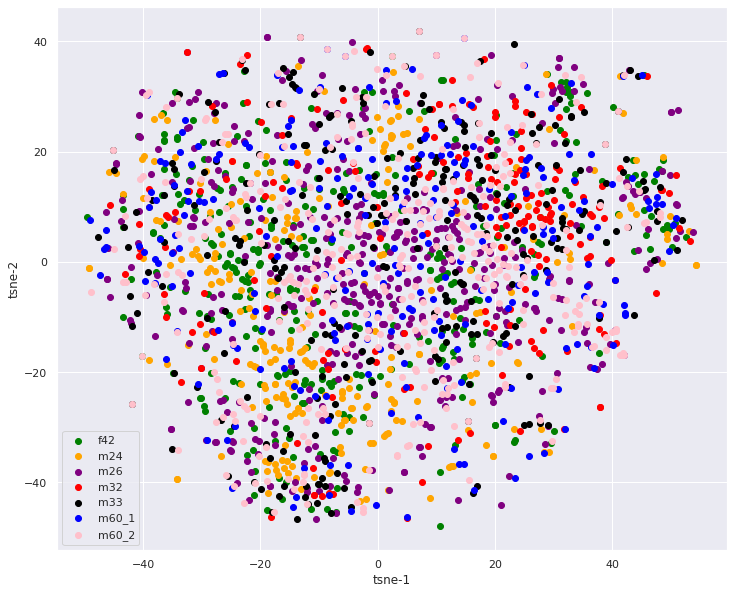

<IPython.core.display.Javascript object>

In [95]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[:, 0]
y = tsne_embedded_cleaned_features[:, 1]
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
colors = ["green", "orange", "purple", "red", "black", "blue", "pink"]
j = 0
for i in range(len(sample_changes)):
    end = j + sample_changes[i]
    scatter = ax.scatter(
        x[j:end], y[j:end], c=colors[i], label=np.unique(sample_labels)[i]
    )
    j = end
# ax.set_xlim([-40, 40])
ax.legend()
plt.show()

We do not see any prominent batch effects in the TSNE visualization.However, to get a feeling of the features that are significantly different between the samples we will run a Kruskal-Wallis H test for each marker that was not filtered out and correct for multiple testing using Bonferroni.

In [96]:
sample_kruskal_screen_results = kruskal_screen(cleaned_all_features, sample_labels)
sample_kruskal_screen_results.head(20)

Progress marker screen: 100%|██████████| 69/69 [00:00<00:00, 218.70it/s]


,marker,pval,fwer_padj
50,nuclear_std_int,6.588309e-171,9.548273e-173
53,q75_dapi_int,5.277478e-161,7.648519e-163
49,nuclear_mean_int,1.605817e-149,2.327272e-151
60,q75_gh2ax_int,2.090240e-107,3.029333e-109
56,rel_gh2ax_int,1.243521e-91,1.802204e-93
54,kurtosis_dapi_int,1.805459e-82,2.616607e-84
65,max_lamin_int,7.377754e-74,1.069240e-75
64,rel_lamin_int,1.984974e-60,2.876775e-62
68,normalized_q75_lamin_int,7.336538e-60,1.063266e-61
21,correlation_1,2.514516e-55,3.644226e-57


<IPython.core.display.Javascript object>

Next, we color the TSNE plot by age and observe that the space is not separated by age.

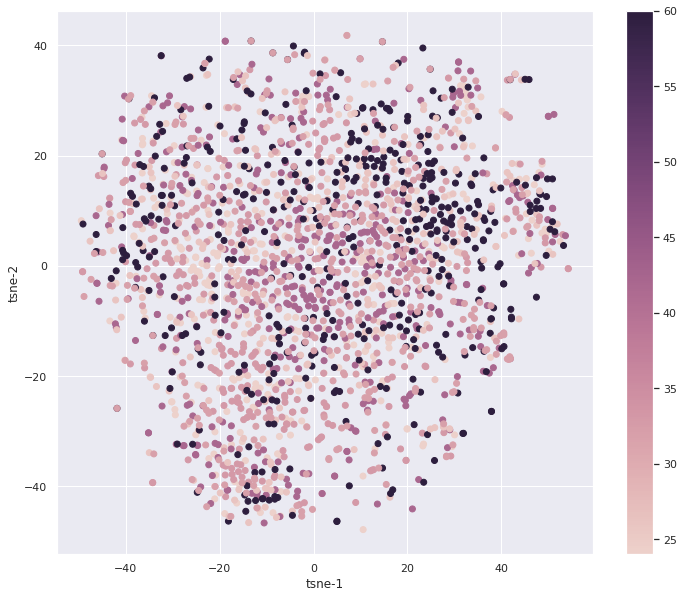

<IPython.core.display.Javascript object>

In [97]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[:, 0]
y = tsne_embedded_cleaned_features[:, 1]
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
cmap = sns.cubehelix_palette(as_cmap=True)
scatter = ax.scatter(x, y, c=cleaned_all_data["age"], cmap=cmap)
fig.colorbar(scatter)
plt.show()

In [98]:
age_labels = np.repeat("young", len(cleaned_all_features))
age_labels[cleaned_all_data["age"] > 30] = "old"

<IPython.core.display.Javascript object>

Again, we run a Kruskal-Wallis H test screen to identify the features that are the most different between the young (age <=30) and old (age>30) samples of the healthy volunteers.

In [99]:
age_kruskal_screen_results = kruskal_screen(cleaned_all_features, age_labels)
age_kruskal_screen_results.head(20)

Progress marker screen: 100%|██████████| 69/69 [00:00<00:00, 985.20it/s]


,marker,pval,fwer_padj
53,q75_dapi_int,1.502279e-32,2.177216e-34
54,kurtosis_dapi_int,1.477118e-28,2.140751e-30
60,q75_gh2ax_int,2.884659e-27,4.180665e-29
68,normalized_q75_lamin_int,8.033883e-18,1.164331e-19
65,max_lamin_int,1.498312e-12,2.171466e-14
59,q25_gh2ax_int,2.645244e-10,3.833686e-12
63,normalized_q25_gh2ax_int,2.715641e-10,3.935711e-12
21,correlation_1,3.506014e-10,5.081180e-12
46,equivalent_diameter_3d,3.953572e-10,5.729815e-12
20,Contrast_1,1.174233e-09,1.701787e-11


<IPython.core.display.Javascript object>

We see the features corresponding to the gH2AX staining to be the most different ones between the young and old samples of the healthy control. This is expected as DNA damage is known to increase during aging.

---

## 4. Heterogeneity in the population

We will now assess how heterogeneous the overall population of the T cells extracted from the different healthy control samples is.

### 4.1. Cluster analysis

To this end, we perform a Gaussian mixture modelling cluster analysis.

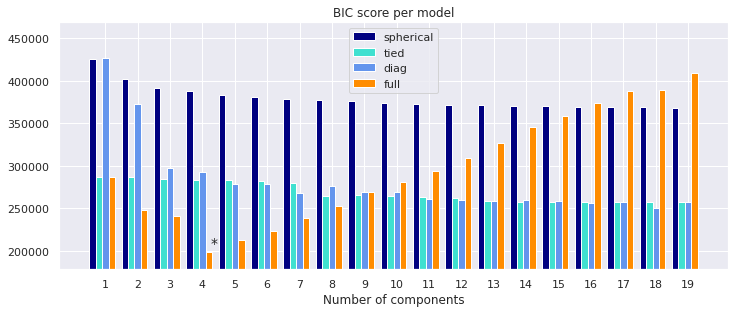

<IPython.core.display.Javascript object>

In [100]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type, random_state=1234
        )
        gmm.fit(scaled_cleaned_all_features)
        bic.append(gmm.bic(scaled_cleaned_all_features))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(12, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 0.9, bic.max() * 1.1])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

In [101]:
print(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)

Selected GMM: full model, 4 components


<IPython.core.display.Javascript object>

We see that the GMM model with lowest BIC for the data consists of four components and uses full covariance structures.

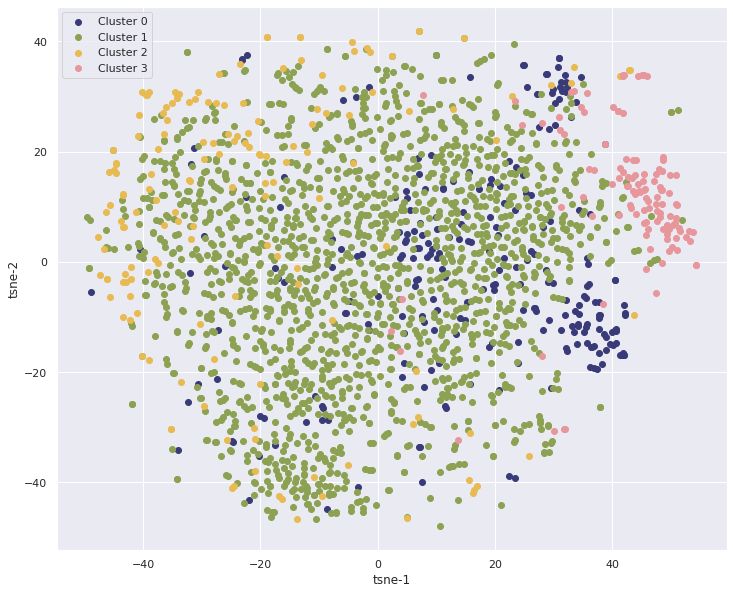

<IPython.core.display.Javascript object>

In [102]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[:, 0]
y = tsne_embedded_cleaned_features[:, 1]
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")

labels = best_gmm.predict(scaled_cleaned_all_features)
cm = plt.get_cmap("tab20b")
# cs = np.vectorize(colors)(labels)

for label in np.unique(labels):
    scatter = ax.scatter(
        x[labels == label],
        y[labels == label],
        c=cm(label / len(np.unique(labels))),
        label="Cluster {}".format(label),
    )
ax.legend()
plt.show()

In [103]:
cluster_means = []
for cluster_label in list(np.unique(labels)):
    cluster_means.append(
        np.mean(scaled_cleaned_all_features[labels == cluster_label], axis=0)
    )
cluster_means = np.array(cluster_means)

<IPython.core.display.Javascript object>

In [104]:
cluster_means = pd.DataFrame(
    cluster_means,
    index=["c{}".format(i) for i in list(np.unique(labels))],
    columns=cleaned_all_features.columns,
)

<IPython.core.display.Javascript object>

In [105]:
cluster_means

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Len_posi_Curvature,Med_neg_Curvature,num_prominant_positive_curvature,width_prominant_positive_curvature,num_prominant_negative_curvature,width_prominant_negative_curvature,...,q25_gh2ax_int,q75_gh2ax_int,kurtosis_gh2ax_int,normalized_std_gh2ax_int,normalized_q25_gh2ax_int,rel_lamin_int,max_lamin_int,kurtosis_lamin_int,normalized_std_lamin_int,normalized_q75_lamin_int
c0,0.224922,-0.111124,-0.214984,-0.187222,-0.129608,0.070742,0.036336,-0.059347,-0.069552,-0.144112,...,0.441493,0.593899,0.175664,0.041656,1.114503,0.177975,0.124918,-0.186882,0.075059,0.696837
c1,0.040338,-0.050161,0.008620,-0.056975,-0.025403,-0.048215,-0.016370,-0.028909,0.004083,0.003444,...,-0.099522,-0.077713,-0.155886,-0.153499,-0.164089,-0.025839,-0.056383,-0.020750,0.010707,-0.040603
c2,-0.905129,1.146644,0.080529,1.141065,0.392949,0.646211,0.523446,0.483649,0.500666,0.283422,...,-0.034851,-0.077492,0.340779,0.048597,-0.098935,-0.034267,0.272957,0.164966,-0.350401,-0.339969
c3,0.180755,-0.610340,0.226793,-0.346604,0.099244,-0.348463,-0.554099,-0.122945,-0.584185,-0.124592,...,0.499003,-0.070474,1.341801,1.986141,0.059594,0.029328,0.153561,0.462919,0.163868,-0.452220


<IPython.core.display.Javascript object>

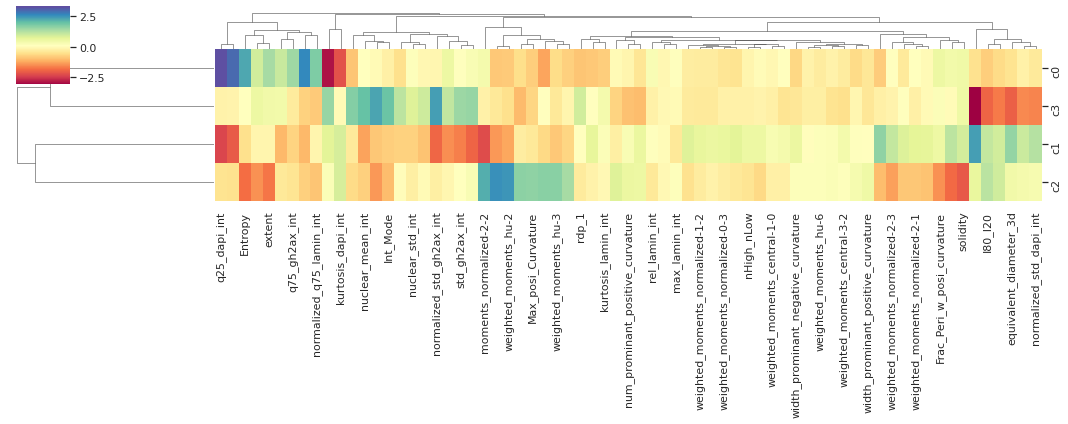

<IPython.core.display.Javascript object>

In [106]:
g = sns.clustermap(
    cluster_means, z_score=0, row_cluster=True, figsize=[15, 6], cmap="Spectral"
)

In [107]:
cluster_label_samples = pd.DataFrame(
    labels, columns=["cluster_label"], index=cleaned_all_data.index
)
cluster_label_samples["sample"] = sample_labels

<IPython.core.display.Javascript object>

In [108]:
cluster_label_samples

,cluster_label,sample
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_0,1,m24
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_1,2,m24
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_2,1,m24
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_3,1,m24
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_4,2,m24
...,...,...
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_32_2,0,m32
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_32_3,1,m32
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_32_4,1,m32
HV7_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit_32_5,1,m32


<IPython.core.display.Javascript object>

In [109]:
cluster_distributions = {}
for sample in list(np.unique(sample_labels)):
    label_counts = Counter(
        list(
            cluster_label_samples.loc[
                cluster_label_samples["sample"] == sample, "cluster_label"
            ]
        )
    )
    cluster_distributions[sample] = dict(label_counts)

<IPython.core.display.Javascript object>

In [110]:
cluster_distributions

{'f42': {1: 330, 3: 17, 0: 67, 2: 39},
 'm24': {1: 264, 2: 30, 3: 24, 0: 19},
 'm26': {1: 231, 3: 18, 2: 20, 0: 13},
 'm32': {1: 270, 2: 21, 0: 80, 3: 11},
 'm33': {1: 228, 3: 15, 0: 5, 2: 12},
 'm60_1': {2: 15, 1: 150, 0: 23, 3: 14},
 'm60_2': {1: 172, 2: 22, 3: 19, 0: 43}}

<IPython.core.display.Javascript object>

In [111]:
Counter(sample_labels)

Counter({'m24': 345,
         'm33': 263,
         'f42': 465,
         'm60_1': 205,
         'm26': 286,
         'm60_2': 262,
         'm32': 393})

<IPython.core.display.Javascript object>

In [112]:
cdis_pd = np.zeros([7, 4])
unique_sample_labels = list(np.unique(sample_labels))
for i in range(7):
    sample = unique_sample_labels[i]
    label_counts = Counter(
        list(
            cluster_label_samples.loc[
                cluster_label_samples["sample"] == sample, "cluster_label"
            ]
        )
    )
    for j in range(4):
        cdis_pd[i, j] = label_counts[j]
    cdis_pd[i] /= cdis_pd[i].sum()
cdis_pd = pd.DataFrame(
    cdis_pd, columns=["c{}".format(i) for i in range(4)], index=unique_sample_labels
)

<IPython.core.display.Javascript object>

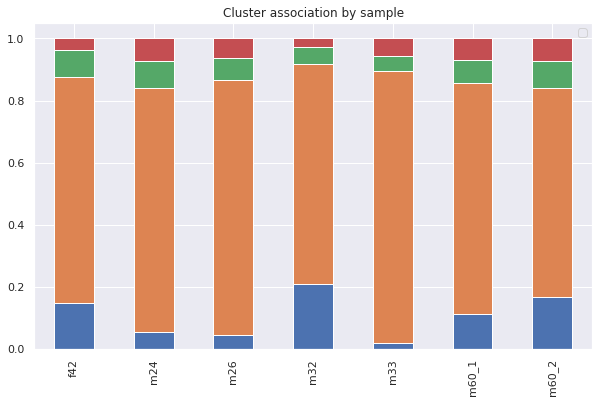

<IPython.core.display.Javascript object>

In [113]:
fig = cdis_pd.plot(kind="bar", stacked=True, figsize=[10, 6])
plt.title("Cluster association by sample")
plt.legend([])
plt.show()

### 4.2. Special features of interest

We now plot the distribution for specific pre-selected features of special interest.

In [114]:
set(all_data.columns)

{'ASM_1',
 'ASM_20',
 'ASM_5',
 'A_R',
 'Area_bbArea',
 'Avg_Curvature',
 'Avg_Radius',
 'Avg_neg_Curvature',
 'Avg_posi_Curvature',
 'Center_Mismatch',
 'Concavity',
 'Contrast_1',
 'Contrast_20',
 'Contrast_5',
 'D25_Radius',
 'D75_Radius',
 'Entropy',
 'Feret_Max',
 'Frac_Peri_w_neg_curvature',
 'Frac_Peri_w_polarity_changes',
 'Frac_Peri_w_posi_curvature',
 'HC_area_EC_area',
 'HC_area_Nuc_area',
 'HC_content_DNA_content',
 'HC_content_EC_content',
 'I80_I20',
 'Int_Max',
 'Int_Mean',
 'Int_Median',
 'Int_Min',
 'Int_Mode',
 'Int_SD',
 'Int_d25',
 'Int_d75',
 'Len_neg_Curvature',
 'Len_posi_Curvature',
 'Max_Calliper',
 'Max_Radius',
 'Max_neg_Curvature',
 'Max_posi_Curvature',
 'Med_Radius',
 'Med_neg_Curvature',
 'Med_posi_Curvature',
 'Min_Calliper',
 'Min_Radius',
 'Mode_Radius',
 'Shape_Factor',
 'Smallest_largest_Calliper',
 'Solidity',
 'Std_Curvature',
 'Std_Radius',
 'Std_neg_Curvature',
 'Std_posi_Curvature',
 'Sum_neg_Curvature',
 'Sum_posi_Curvature',
 'age',
 'area',
 

<IPython.core.display.Javascript object>

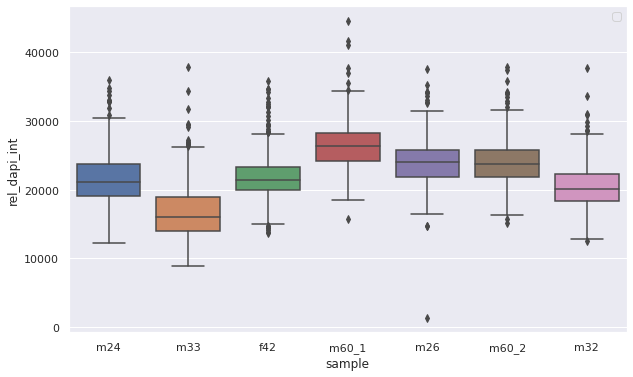

<IPython.core.display.Javascript object>

In [154]:
plt.figure(figsize=[10, 6])
ax = sns.boxplot(x="sample", y="rel_dapi_int", data=all_data)
plt.legend([])
plt.show()

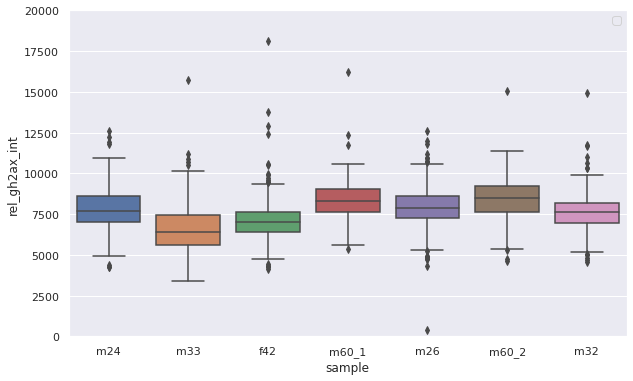

<IPython.core.display.Javascript object>

In [131]:
plt.figure(figsize=[10, 6])
ax = sns.boxplot(
    x="sample", y="rel_gh2ax_int", data=all_data
)
ax.set_ylim([0,20000])
plt.legend([])
plt.show()

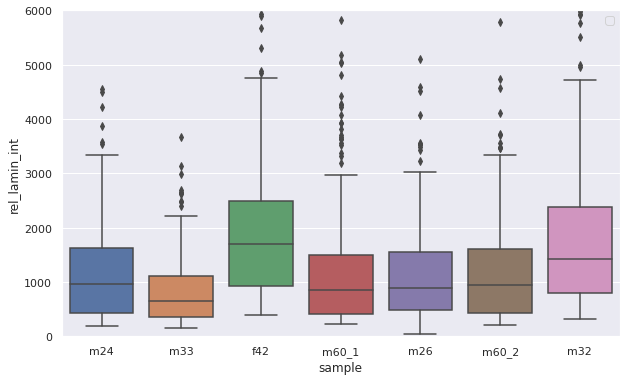

<IPython.core.display.Javascript object>

In [130]:
plt.figure(figsize=[10, 6])
ax = sns.boxplot(
    x="sample", y="rel_lamin_int", data=all_data
)
plt.legend([])
ax.set_ylim([0,6000])
plt.show()


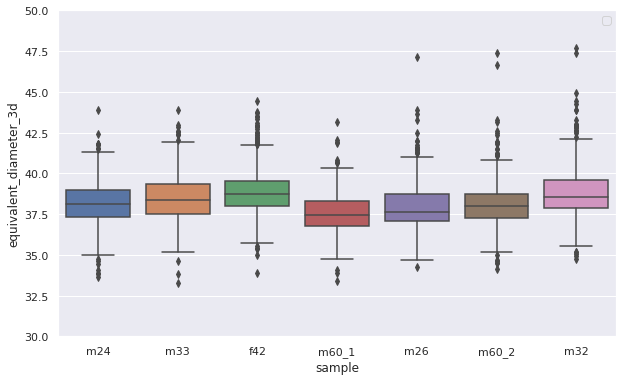

<IPython.core.display.Javascript object>

In [136]:
plt.figure(figsize=[10, 6])
ax = sns.boxplot(x="sample", y="equivalent_diameter_3d", data=all_data)
plt.legend([])
ax.set_ylim([30, 50])
plt.show()

In [146]:
all_data["age_ind"] = np.repeat("young", len(all_data))
all_data.loc[all_data["age"] > 50, "age_ind"] = "old"

<IPython.core.display.Javascript object>

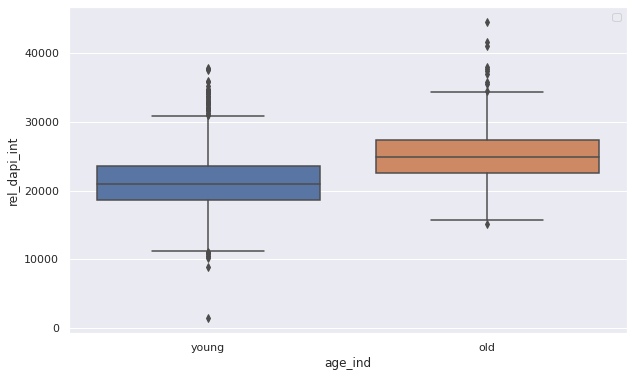

<IPython.core.display.Javascript object>

In [152]:
plt.figure(figsize=[10, 6])
ax = sns.boxplot(x="age_ind", y="rel_dapi_int", data=all_data)
plt.legend([])
plt.show()

In [153]:
ranksums(
    np.array(all_data.loc[all_data["age_ind"] == "young", "rel_dapi_int"]),
    np.array(all_data.loc[all_data["age_ind"] != "young", "rel_dapi_int"]),
)

RanksumsResult(statistic=-18.181486573445717, pvalue=7.234578480627608e-74)

<IPython.core.display.Javascript object>

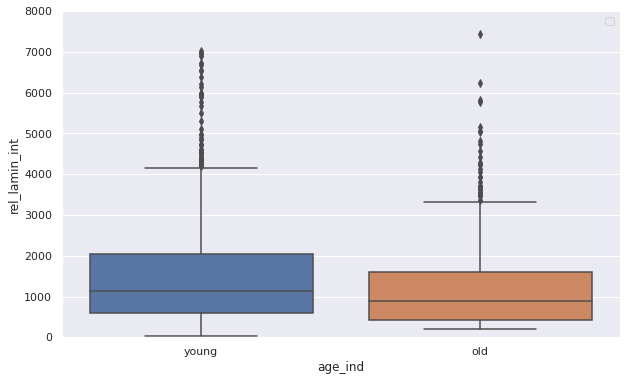

<IPython.core.display.Javascript object>

In [147]:
plt.figure(figsize=[10, 6])
ax = sns.boxplot(x="age_ind", y="rel_lamin_int", data=all_data)
plt.legend([])
ax.set_ylim([0, 8000])
plt.show()

In [150]:
ranksums(
    np.array(all_data.loc[all_data["age_ind"] == "young", "rel_lamin_int"]),
    np.array(all_data.loc[all_data["age_ind"] != "young", "rel_lamin_int"]),
)

RanksumsResult(statistic=4.6232590910405715, pvalue=3.7775740586526103e-06)

<IPython.core.display.Javascript object>

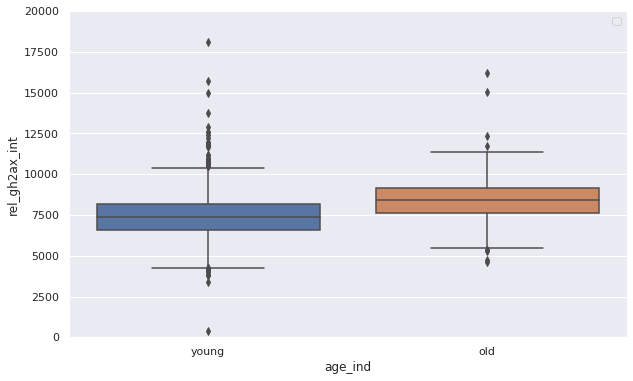

<IPython.core.display.Javascript object>

In [148]:
plt.figure(figsize=[10, 6])
ax = sns.boxplot(x="age_ind", y="rel_gh2ax_int", data=all_data)
plt.legend([])
ax.set_ylim([0, 20000])
plt.show()

In [149]:
from scipy.stats import ranksums

ranksums(
    np.array(all_data.loc[all_data["age_ind"] == "young", "rel_gh2ax_int"]),
    np.array(all_data.loc[all_data["age_ind"] != "young", "rel_gh2ax_int"]),
)

RanksumsResult(statistic=-15.017545234172768, pvalue=5.635640493356569e-51)

<IPython.core.display.Javascript object>